In [1]:
import os
import sys

import pandas as pd
import geopandas as gpd
import numpy as np

import math

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup
else:
    import aup

In [2]:
schema = 'hexgrid'
folder = 'hexgrid_9_city_2020'
city = 'Guadalajara'
type_area = 'urban'

query = f"SELECT * FROM {schema}.{folder} WHERE \"city\" = \'{city}\' AND \"type\" = \'{type_area}\'"

hex_gdf = aup.gdf_from_query(query)
print(hex_gdf.shape)
hex_gdf.head(2)

(6540, 6)


,hex_id_9,geometry,CVEGEO,NOMGEO,city,type
0,89498c96e0bffff,"POLYGON ((-103.35267 20.66765, -103.35145 20.6...",14039,Guadalajara,Guadalajara,urban
1,89498c960a3ffff,"POLYGON ((-103.34713 20.62771, -103.34591 20.6...",14039,Guadalajara,Guadalajara,urban


### Census data

In [3]:
schema = 'sociodemografico'
folder = 'pobvoronoi_inegi_20_mzaageb_hex'

query = f"SELECT hex_id,pobtot FROM {schema}.{folder} WHERE  \"hex_id\" IN {str(tuple(list(hex_gdf.hex_id_9.unique())))}"
censo_gdf = aup.df_from_query(query)

print(censo_gdf.shape)
censo_gdf.head(2)

(6540, 2)


,hex_id,pobtot
0,89498c96e0bffff,968.174011
1,89498c94053ffff,1763.952026


### Area of Interest

In [4]:
aoi_gdf = gpd.read_file('../../../data/processed/viviendas_tlajo/AOI_Viviendas_Tlajo.geojson')
aoi_gdf = aoi_gdf.to_crs("EPSG:32613")
print(aoi_gdf.shape)
aoi_gdf.head(1)

(106, 11)


,hex_id,CVEGEO,NOMGEO,city,type,pct_BANQUETA,pct_ALUMPUB,pct_RAMPAS,pct_ARBOLES,pct_CICLOVIA,geometry
0,8949aa2ea37ffff,14097,Tlajomulco de Zúñiga,Guadalajara,urban,0.438522,0.43849,0.299607,0.402497,0.0,"POLYGON ((668991.147 2270868.529, 669116.373 2..."


Buffer from AOI

In [5]:
aoi_buffer = aoi_gdf.copy()
aoi_buffer = aoi_buffer.dissolve()
aoi_buffer['geometry'] = aoi_buffer.buffer(500)
print(aoi_buffer.shape)

(1, 11)


### Nodes, edges

In [6]:
aoi_buffer = aoi_buffer.to_crs("EPSG:4326")

G,nodes,edges = aup.graph_from_hippo(aoi_buffer, schema='osmnx', 
                    edges_folder='edges_speed_23_line', nodes_folder='nodes_osmnx_23_point')
print('nodes:',nodes.shape,'edges:',edges.shape)

nodes: (5291, 5) edges: (12386, 19)


### NDVI

In [7]:
schema = 'raster_analysis'
folder = 'ndvi_analysis_hex'

query = f"SELECT hex_id,ndvi_mean FROM {schema}.{folder} WHERE  \"hex_id\" IN {str(tuple(list(hex_gdf.hex_id_9.unique())))}"
ndvi_df = aup.df_from_query(query)

print(ndvi_df.shape)
ndvi_df.head(2)

(6540, 2)


,hex_id,ndvi_mean
0,89498c96123ffff,0.127472
1,8949ab4b697ffff,0.382025


Hexágonos de resolución 11 filtrando aquellos con NDVI > 0.2. Calcular área. Extraer centroides. Intersección con hexágonos. Sumar área. Dividir entre población.

### Heat islands

In [8]:
schema = 'raster_analysis'
folder = 'temperature_analysis_hex'

query = f"SELECT hex_id,temperature_mean FROM {schema}.{folder} WHERE  \"hex_id\" IN {str(tuple(list(hex_gdf.hex_id_9.unique())))}"
temp_df = aup.df_from_query(query)
mean_temp = float(temp_df['temperature_mean'].replace([np.inf, -np.inf], np.nan).mean()) # remove infinite values from gdf
temp_df.replace([np.inf, -np.inf], mean_temp, inplace=True)
temp_df['temperature_mean'] = temp_df['temperature_mean'] - mean_temp

print(temp_df.shape)
temp_df.head(2)

(6540, 2)


,hex_id,temperature_mean
0,89498c96e0bffff,2.040944
1,89498c960a3ffff,1.242303


### NDMI

In [9]:
schema = 'raster_analysis'
folder = 'ndmi_analysis_hex'

query = f"SELECT hex_id,ndmi_diff FROM {schema}.{folder} WHERE  \"hex_id\" IN {str(tuple(list(hex_gdf.hex_id_9.unique())))}"
ndmi_df = aup.df_from_query(query)

print(ndmi_df.shape)
ndmi_df.head(2)

(6540, 2)


,hex_id,ndmi_diff
0,8949ab5b527ffff,0.043084
1,8949aa2e817ffff,0.160681


### Green spaces point

In [10]:
green_point = gpd.read_file('../../../data/processed/viviendas_tlajo/espacios_publicos_point_amg.geojson')
print(green_point.shape)
green_point.head(2)

(266292, 5)


,Fuente,Tipo,Uso,geom_type,geometry
0,"OpenStreetMap, [Online]. Disponible: http://ww...",Parque,Uso recreativo,Point,POINT (672507.028 2272132.201)
1,"OpenStreetMap, [Online]. Disponible: http://ww...",Parque,Uso recreativo,Point,POINT (672520.126 2272170.353)


### Green spaces area

In [11]:
green_area = gpd.read_file('../../../data/processed/viviendas_tlajo/espacios_publicos_amg.geojson')
print(green_area.shape)
green_area.head(2)

(8499, 4)


,Fuente,Tipo,Uso,geometry
0,"OpenStreetMap, [Online]. Disponible: http://ww...",Parque,Uso recreativo,"POLYGON ((672507.028 2272132.201, 672520.126 2..."
1,"OpenStreetMap, [Online]. Disponible: http://ww...",Parque,Uso recreativo,"POLYGON ((672520.126 2272170.353, 672507.028 2..."


## m² per person

Public space area

In [12]:
green_area['area_m2'] = green_area.area

Public spaces to hex

In [13]:
hex_green = green_area.overlay(hex_gdf.to_crs("EPSG:32613"), how='intersection')
hex_green = hex_green.groupby('hex_id_9').sum(numeric_only=True)
hex_green = hex_green.reset_index()
print(hex_green.shape)
hex_green.head(2)

(3604, 2)


,hex_id_9,area_m2
0,89498c86487ffff,41050.605215
1,89498c86497ffff,305.824768


In [14]:
hex_green = hex_green.merge(censo_gdf, left_on='hex_id_9',
                            right_on='hex_id', how='left')
hex_green.loc[hex_green.pobtot==0,'pobtot'] = 1
hex_green['area_pob'] = hex_green['area_m2'] / hex_green['pobtot']
hex_green = hex_green.fillna(0)
print(hex_green.shape)
hex_green.head(2)

(3604, 5)


,hex_id_9,area_m2,hex_id,pobtot,area_pob
0,89498c86487ffff,41050.605215,89498c86487ffff,809.293823,50.723982
1,89498c86497ffff,305.824768,89498c86497ffff,1448.858643,0.211080


In [15]:
hex_green.loc[hex_green.area_pob>250,'area_pob'] = 250
hex_green = hex_green.merge(hex_gdf[['hex_id_9','geometry']],
                           on='hex_id_9', how='right')
hex_green = hex_green.fillna(0)
hex_green = gpd.GeoDataFrame(hex_green, geometry='geometry')
hex_green = hex_green.set_crs("EPSG:4326")

<Axes: >

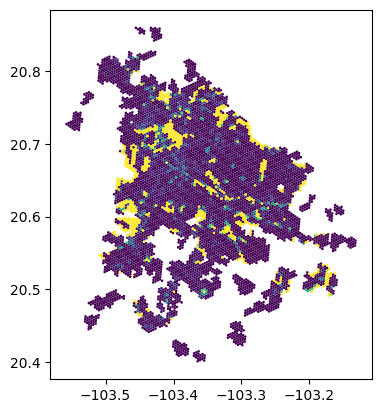

In [16]:
hex_green.plot('area_pob')

## Proximity to green spaces

### Proximity evaluation

In [17]:
green_point = green_point.to_crs("EPSG:4326")
green_point = green_point.clip(aoi_buffer)
print(green_point.shape)
green_point.head(2)

(8389, 5)


,Fuente,Tipo,Uso,geom_type,geometry
72145,Instrumentos de planeación urbana. Disponible:...,Parque,Uso recreativo,Point,POINT (-103.35672 20.48881)
72147,Instrumentos de planeación urbana. Disponible:...,Parque,Uso recreativo,Point,POINT (-103.35673 20.48881)


In [18]:
green_osmid = aup.find_nearest(G, nodes, green_point, return_distance= True)
nodes_green = aup.calculate_distance_nearest_poi(green_osmid, nodes, 
                                       edges, 'ep', 'osmid', wght='time_min')
nodes_green = nodes_green.reset_index()
nodes_green.head(4)

,osmid,x,y,street_count,geometry,city,dist_ep
0,1675924421,-103.378025,20.521124,1,POINT (-103.37803 20.52112),Guadalajara,2.135420
1,1750578918,-103.379185,20.510326,3,POINT (-103.37919 20.51033),Guadalajara,1.938133
2,1750578919,-103.379075,20.510316,3,POINT (-103.37907 20.51032),Guadalajara,2.111263
3,1750578932,-103.369503,20.511927,4,POINT (-103.3695 20.51193),Guadalajara,1.320577


In [20]:
nodes_green = nodes_green.to_crs("EPSG:32613")
hex_gdf = hex_gdf.to_crs("EPSG:32613")
hex_prox = aup.group_by_hex_mean(nodes_green, hex_gdf, 'dist_ep', 'hex_id_9')
print(hex_prox.shape)
hex_prox.head(2)

(6540, 10)


,hex_id_9,geometry,CVEGEO,NOMGEO,city,type,x,y,street_count,dist_ep
6032,89498c86483ffff,"POLYGON ((674140.273 2296867.03, 674265.512 22...",14120,Zapopan,Guadalajara,urban,0.0,0.0,0.0,0.0
5279,89498c86487ffff,"POLYGON ((673827.676 2297081.244, 673952.915 2...",14120,Zapopan,Guadalajara,urban,0.0,0.0,0.0,0.0


<Axes: >

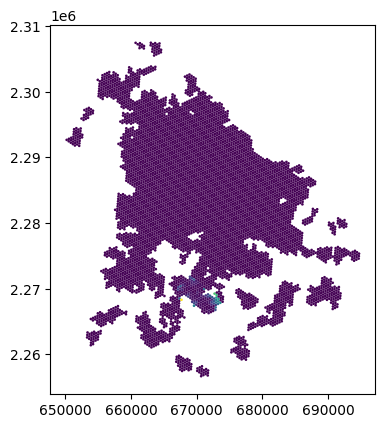

In [21]:
hex_prox.plot('dist_ep')

## Merge data

In [27]:
hex_env = aoi_gdf[['hex_id','geometry']].merge(ndvi_df[['hex_id','ndvi_mean']],
                        left_on='hex_id', right_on='hex_id',
                        how='left')
hex_env = hex_env.merge(ndmi_df[['hex_id','ndmi_diff']], 
                        left_on='hex_id', right_on='hex_id', how='left')
hex_env = hex_env.merge(temp_df[['hex_id','temperature_mean']], 
                        left_on='hex_id', right_on='hex_id', how='left')
hex_env = hex_env.merge(hex_green[['hex_id_9','area_m2','area_pob']], 
                        left_on='hex_id', right_on='hex_id_9', how='left')
hex_env = hex_env.merge(hex_prox[['hex_id_9','dist_ep']], 
                        left_on='hex_id', right_on='hex_id_9', how='left')

In [28]:
hex_env.head(2)

,hex_id,geometry,ndvi_mean,ndmi_diff,temperature_mean,hex_id_9_x,area_m2,area_pob,hex_id_9_y,dist_ep
0,8949aa2ea37ffff,"POLYGON ((668991.147 2270868.529, 669116.373 2...",0.193727,0.129067,1.620926,8949aa2ea37ffff,10776.654773,10.372178,8949aa2ea37ffff,1.658878
1,8949aa2eac7ffff,"POLYGON ((670209.642 2269635.158, 670334.867 2...",0.284946,0.156894,2.577832,8949aa2eac7ffff,5410.108327,6.801595,8949aa2eac7ffff,1.052899


In [29]:
hex_env = hex_env.drop(columns=['hex_id_9_x','hex_id_9_y'])

In [30]:
hex_env.to_file('../../../data/processed/viviendas_tlajo/hex_environmental.geojson')